In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras import layers, models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.applications import DenseNet201
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Layer, Multiply, Add, Activation
from tensorflow.keras.utils import plot_model  # Import plot_model



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#generators
source_dir="/content/drive/MyDrive/rice"
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    source_dir,
    validation_split=0.2,
    seed=123,
    subset="training",
    labels="inferred",
    batch_size=32,
    image_size=(224,224)
)
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    source_dir,
    validation_split=0.2,
    seed=123,
    subset="validation",
    labels="inferred",
    batch_size=32,
    image_size=(224,224)
)


Found 10000 files belonging to 4 classes.
Using 8000 files for training.
Found 10000 files belonging to 4 classes.
Using 2000 files for validation.


In [ ]:
normalization_layer=tf.keras.layers.Rescaling(1./255)

In [ ]:
import numpy as np
normalized_ds=train_ds.map(lambda x,y:(normalization_layer(x),y))
image_batch,labels_batch=next(iter(normalized_ds))
first_image=image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 1.0


In [ ]:
AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [ ]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

In [ ]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB4

# Assuming the desired input shape for your dataset
input_shape = (224, 224, 3)  # Replace with the actual input shape

# Load EfficientNetB4 pre-trained on ImageNet without the top (classification) layer
efficientnet_b4 = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)

def create_attention_block(x, channels, reduction_ratio=8):
    # Convolutional layer
    x = tf.keras.layers.Conv2D(channels, 3, activation='elu', padding='same')(x)

    # Channel-wise attention
    attention_channel = ChannelAttention(channels, reduction_ratio)(x)

    # Spatial attention
    attention_spatial = SpatialAttention(kernel_size=7)(attention_channel)

    # Concatenate with the original tensor and attention mechanisms
    x = tf.keras.layers.concatenate([x, attention_channel, attention_spatial], axis=-1)

    return x


# Build the model with attention layers between blocks
input_tensor = Input(shape=input_shape)
x = efficientnet_b4(input_tensor)

# Add attention layers between blocks
channels_list = [32, 64, 128, 256, 512]

for channels in channels_list:
    x = create_attention_block(x, channels)

# Global Average Pooling and Dense layer for classification
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(4, activation='softmax')(x)  # Assuming you've defined num_classes

# Create the model
efficientnet_with_attention = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
efficientnet_with_attention.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


71892840/71892840 [==============================] - 2s 0us/step


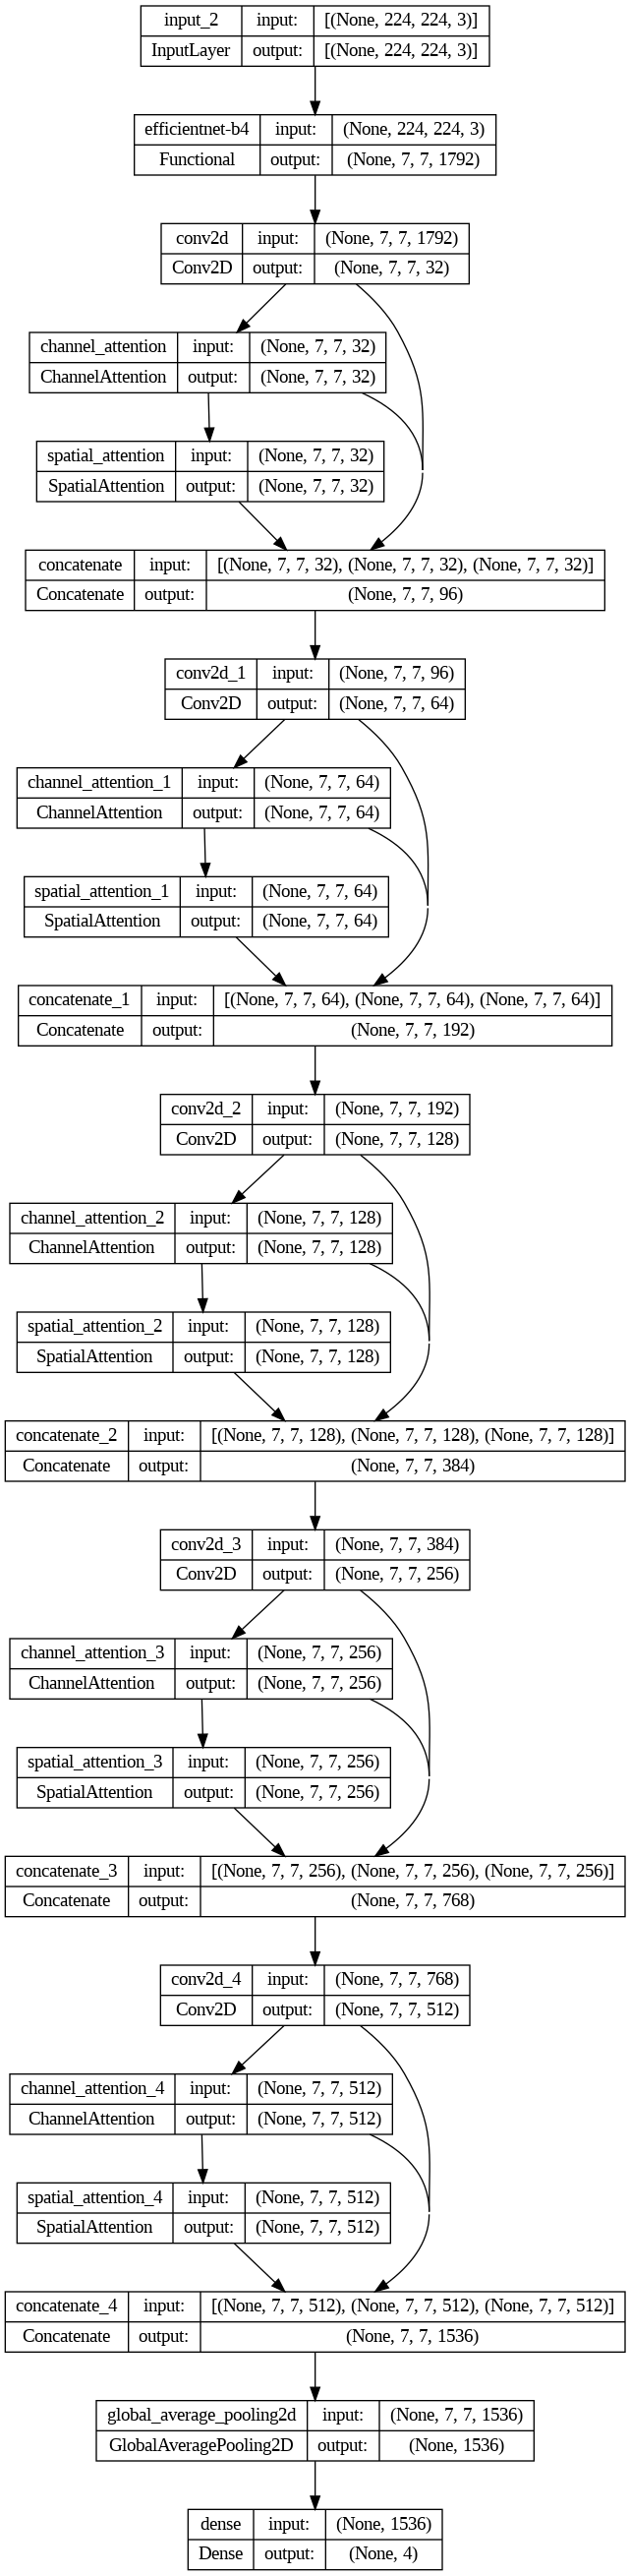

In [ ]:
# Save the model architecture as an image file
plot_model(efficientnet_with_attention, to_file='efficientnet_with_attention.png', show_shapes=True, show_layer_names=True)

In [ ]:
efficientnet_with_attention.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnet-b4 (Functiona  (None, 7, 7, 1792)           1767381   ['input_2[0][0]']             
 l)                                                       6                                       
                                                                                                  
 conv2d (Conv2D)             (None, 7, 7, 32)             516128    ['efficientnet-b4[0][0]']     
                                                                                                  
 channel_attention (Channel  (None, 7, 7, 32)             0         ['conv2d[0][0]']          

In [ ]:
# Model Compilation
learning_rate = 0.0001
efficientnet_with_attention.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)

# Training Loop
num_epochs = 50
history = efficientnet_with_attention.fit(train_ds, epochs=num_epochs, validation_data=val_ds, verbose=1, callbacks=[early_stopping])

Epoch 1/50
250/250 [==============================] - 1350s 5s/step - loss: 0.7111 - accuracy: 0.7120 - val_loss: 0.6041 - val_accuracy: 0.7625
Epoch 2/50
250/250 [==============================] - 62s 247ms/step - loss: 0.4370 - accuracy: 0.8330 - val_loss: 0.5058 - val_accuracy: 0.8245
Epoch 3/50
250/250 [==============================] - 62s 247ms/step - loss: 0.2759 - accuracy: 0.8972 - val_loss: 0.4782 - val_accuracy: 0.8535
Epoch 4/50
250/250 [==============================] - 62s 248ms/step - loss: 0.1897 - accuracy: 0.9324 - val_loss: 0.5370 - val_accuracy: 0.8520
Epoch 5/50
250/250 [==============================] - 63s 254ms/step - loss: 0.1377 - accuracy: 0.9501 - val_loss: 0.3911 - val_accuracy: 0.8885
Epoch 6/50
250/250 [==============================] - 63s 253ms/step - loss: 0.1128 - accuracy: 0.9611 - val_loss: 0.4490 - val_accuracy: 0.8875
Epoch 7/50
250/250 [==============================] - 64s 255ms/step - loss: 0.0778 - accuracy: 0.9736 - val_loss: 0.4923 - val_acc

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [ ]:
def predict_labels(model, dataset):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        predictions = model.predict(images)  # Assuming it's an early fusion model with two input branches
        predicted_labels = np.argmax(predictions, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(predicted_labels)

    return np.array(y_true), np.array(y_pred)


1/1 [==============================] - 3s 3s/step


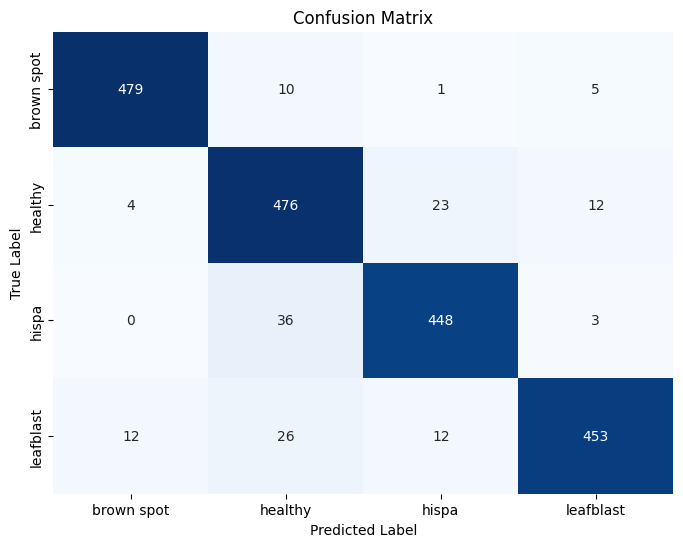

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       495
           1       0.87      0.92      0.90       515
           2       0.93      0.92      0.92       487
           3       0.96      0.90      0.93       503

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [ ]:
# Get true and predicted labels
true_labels, predicted_labels = predict_labels(efficientnet_with_attention, val_ds)

# Define class names
class_names = ["brown spot", "healthy", "hispa", "leafblast"]

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn for better visualization
df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels))

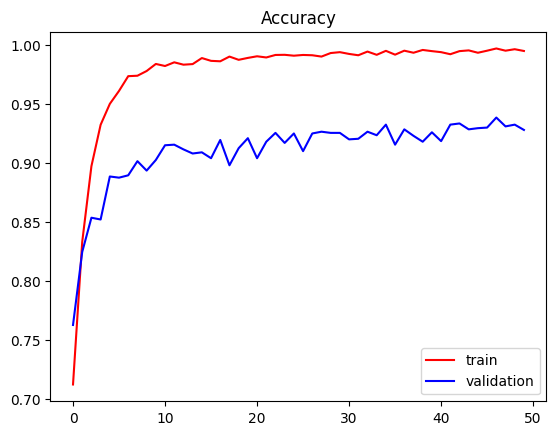

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.title('Accuracy')
plt.show()

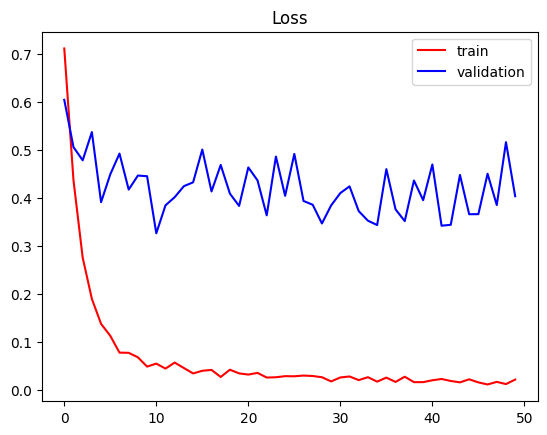

In [ ]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.title('Loss')
plt.show()